In [12]:
df = read.csv('medicaid_costs_for_graphics.csv')

library(dplyr)
library(ggplot2)

Get data in correct format

In [13]:
df$drug_spending = df$drug_spending %>% sub('\\$','',.) %>% gsub('\\,','',.) %>% as.numeric(.)
df$drug_rebates = df$drug_rebates %>% sub('\\$','',.) %>% gsub('\\,','',.) %>% as.numeric(.)
df$spending_less_rebates = df$spending_less_rebates %>% sub('\\$','',.) %>% gsub('\\,','',.) %>% as.numeric(.)
df$medicaid_state = df$medicaid_state %>% sub('\\$','',.) %>% gsub('\\,','',.) %>% as.numeric(.)
df$medicaid_federal = df$medicaid_federal %>% sub('\\$','',.) %>% gsub('\\,','',.) %>% as.numeric(.)
df$medicaid_total = df$medicaid_total %>% sub('\\$','',.) %>% gsub('\\,','',.) %>% as.numeric(.)
df$all_spending_state = df$all_spending_state %>% sub('\\$','',.) %>% gsub('\\,','',.) %>% as.numeric(.)
df$all_spending_federal = df$all_spending_federal %>% sub('\\$','',.) %>% gsub('\\,','',.) %>% as.numeric(.)
df$all_spending_total = df$all_spending_total %>% sub('\\$','',.) %>% gsub('\\,','',.) %>% as.numeric(.)
df$drugs_as_share_of_medicaid = df$drugs_as_share_of_medicaid %>% sub('\\%','',.) %>% as.character(.) %>% as.numeric(.)
df$medicaid_as_share_of_all_spending = df$medicaid_as_share_of_all_spending %>% sub('\\%','',.) %>% as.character(.) %>% as.numeric(.)

Total spending by state over time

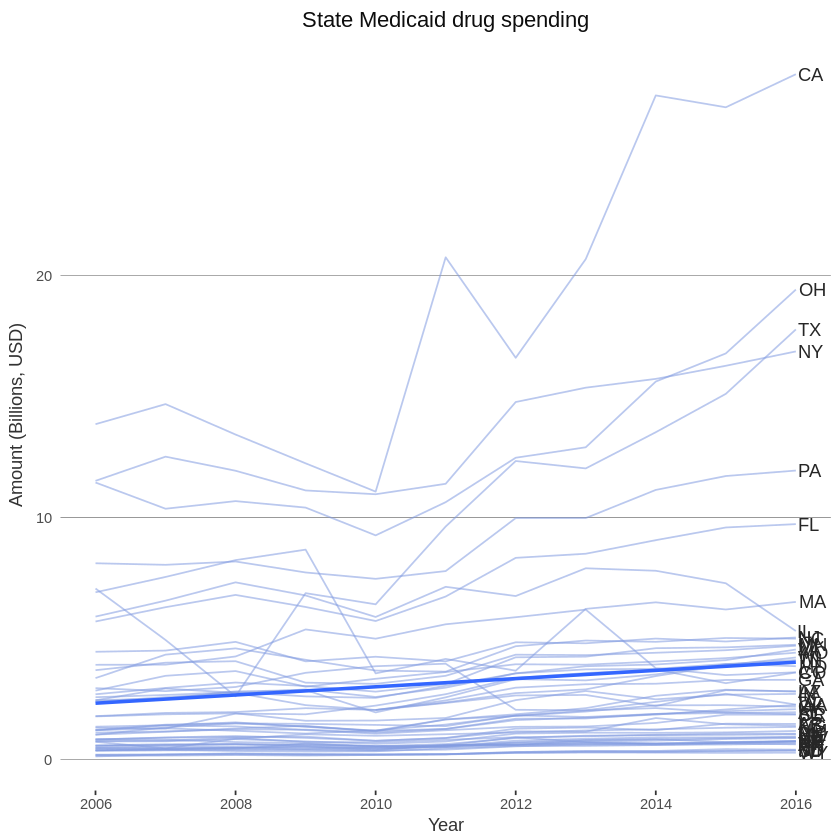

In [14]:
ggplot(df, aes(period_covered,medicaid_state/1000000000,group = st_abbreviation)) +
  geom_line(aes(alpha = .4), color = '#829be0') +
  geom_text(data = df[df$period_covered == max(df$period_covered),],
            aes(label = st_abbreviation),
            color = 'gray15',
            hjust = -.1) +
  theme(legend.position = 'none',
        panel.background = element_blank(),
        axis.ticks.y = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_line(color = 'black', size = .1),
        axis.title.x = element_text(color = 'gray20'),
        axis.title.y = element_text(color = 'gray20'),
        plot.title = element_text(colour = 'gray5', vjust = .5, hjust = 0.5)) +
  xlab('Year') +
  ylab('Amount (Billions, USD)') +
  ggtitle('State Medicaid drug spending') +
  geom_smooth(aes(group = 1), method = 'lm', group = 1, se = FALSE)

Spending as percentage of state budget by state, over time

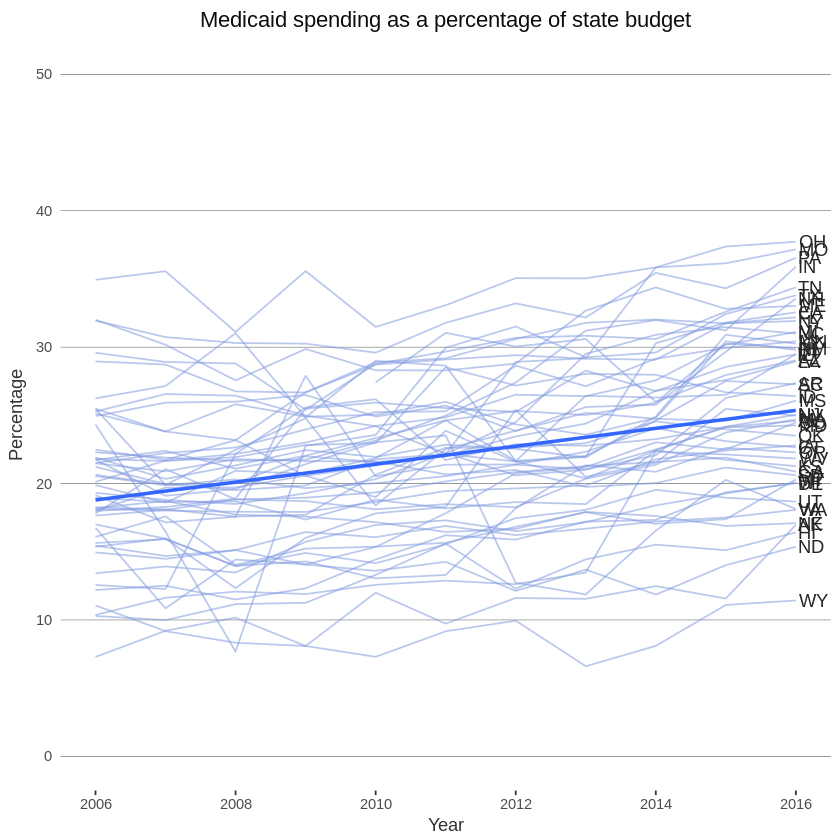

In [15]:
ggplot(df, aes(period_covered,medicaid_as_share_of_all_spending,group = st_abbreviation)) +
  geom_line(aes(alpha = .4), color = '#829be0') +
  geom_text(data = df[df$period_covered == max(df$period_covered),],
            aes(label = st_abbreviation),
            color = 'gray15',
            hjust = -.1) +
  theme(legend.position = 'none',
        panel.background = element_blank(),
        axis.ticks.y = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_line(color = 'black', size = .1),
        axis.title.x = element_text(color = 'gray20'),
        axis.title.y = element_text(color = 'gray20'),
        plot.title = element_text(colour = 'gray5', vjust = .5, hjust = 0.5)) +
  xlab('Year') +
  ylab('Percentage') +
  ylim(c(0,50)) +
  ggtitle('Medicaid spending as a percentage of state budget') +
  geom_smooth(aes(group = 1), method = 'lm', se = FALSE)

Spending as percent change from 2006 over time

In [18]:
temp = df %>%
    group_by(period_covered,st_abbreviation) %>%
    select(period_covered,st_abbreviation,medicaid_state) %>%
    filter(period_covered == 2006)

temp = temp[c(2:3)]
colnames(temp) = c('st_abbreviation', 'baseline')

df = full_join(df, temp, by = 'st_abbreviation')

In [31]:
df$pct_change_2006 = ((df$medicaid_state - df$baseline)/df$baseline)*100

avg_change = df %>% group_by(period_covered) %>% summarise(pct_change_2006 = mean(pct_change_2006, na.rm = TRUE))

In [33]:
avg_change

period_covered,pct_change_2006
2006,0.000000
2007,6.382236
2008,12.853851
2009,9.485872
2010,1.428978
2011,17.617197
2012,41.502098
2013,50.518872
2014,57.610960
2015,63.463181


Warning message:
“Removed 1 rows containing missing values (geom_text).”

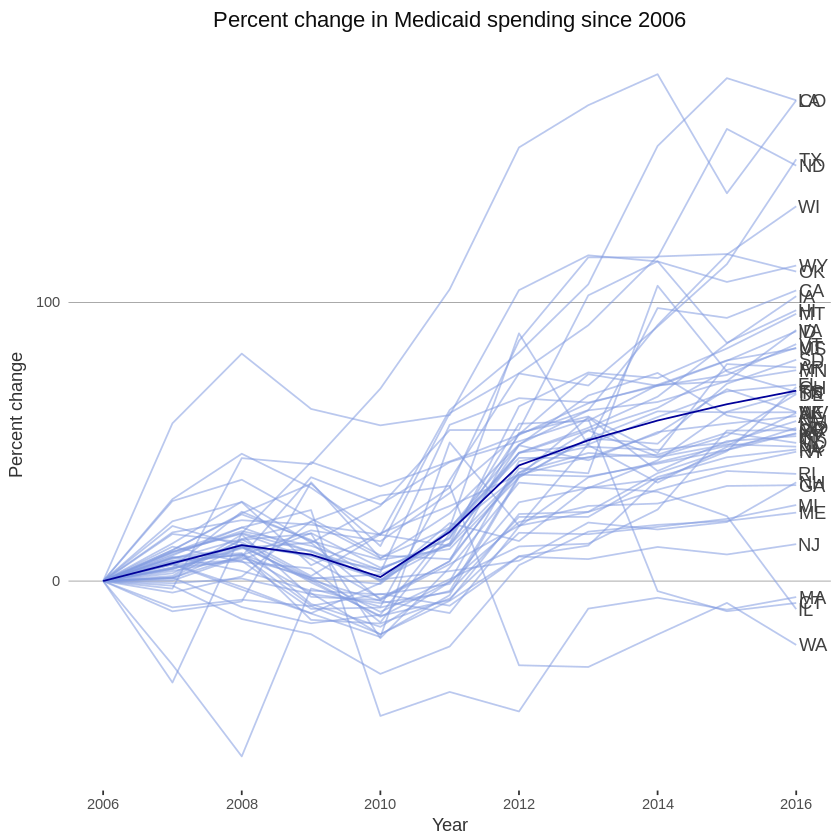

In [37]:
ggplot(df, aes(period_covered,pct_change_2006)) +
  geom_line(aes(alpha = .4, group = st_abbreviation), color = '#829be0') +
  geom_text(data = df[df$period_covered == max(df$period_covered),],
            aes(label = st_abbreviation),
            color = 'gray25',
            hjust = -.1) +
  theme(legend.position = 'none',
        panel.background = element_blank(),
        axis.ticks.y = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_line(color = 'black', size = .1),
        axis.title.x = element_text(color = 'gray20'),
        axis.title.y = element_text(color = 'gray20'),
        plot.title = element_text(colour = 'gray5', vjust = .5, hjust = 0.5)) +
  xlab('Year') +
  ylab('Percent change') +
  ggtitle('Percent change in Medicaid spending since 2006') +
  geom_line(data = avg_change, color = '#000099')